In [1]:
import warnings
import torch
from math import factorial
import numpy as np
import torch.nn.functional as F  # PyTorch's functional module
import torchaudio.functional as AF
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import sys
import time
from datetime import datetime
import os

#torch.set_printoptions(threshold=sys.maxsize)

#warnings.filterwarnings('ignore')  # Suppress 'casting to real discards complex part' warning

# Move tensors to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_to_pt(inp,output_pt):
    f = torch.from_numpy(np.loadtxt(inp))
    torch.save(f,output_pt)

# Define a function to load data
def load(freqs, deltas, rpumps_inp, inp_inp):
    global wg, we, delta, convEL, theta, D, L, M, E0, th, EL, tm, tp, E0_range, gamma, k, beta, eta, S, order, Q, preA, preF, preR, boltz_coef, rshift, b, rpumps, res, n, T, s_reorg, w_reorg, reorg, convergence, inp
    
    convert_to_pt(freqs+'.dat',freqs+'.pt')
    convert_to_pt(deltas+'.dat',deltas+'.pt')
    convert_to_pt(rpumps_inp+'.dat',rpumps_inp+'.pt')
    # Load data to the GPU and convert to PyTorch tensors
    wg = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Ground state normal mode frequencies cm^-1
    we = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Excited state normal mode frequencies cm^-1
    delta = torch.tensor(torch.load(deltas+'.pt'), device=device)  # Dimensionless displacements
    S = (delta ** 2) / 2

    with open(inp_inp, 'r') as i:  # loading inp.txt
        inp = i.readlines()
        j = 0
        for l in inp:
            l = l.partition('#')[0]
            l = l.rstrip()
            inp[j] = l
            j += 1

        hbar = torch.tensor(5.3088, dtype=torch.float32, device=device)  # planck's constant cm^-1*ps
        T = torch.tensor(float(inp[13]), dtype=torch.float32, device=device)  # Temperature K
        kbT = 0.695 * T  # kbT energy (cm^-1/K)*cm^-1=cm^-1
        cutoff = kbT * 0.1  # cutoff for boltzmann distribution in wavenumbers

        if T > 10.0:
            beta = 1 / kbT  # beta cm
            eta = 1 / (torch.exp(wg / kbT) - 1)  # array of average thermal occupation numbers for each mode
        elif T < 10.0:
            beta = 1 / kbT
            eta = torch.zeros(len(wg), device=device)

        gamma = torch.tensor(float(inp[0]), dtype=torch.float32, device=device)  # Homogeneous broadening parameter cm^-1
        theta = torch.tensor(float(inp[1]), dtype=torch.float32, device=device)  # Static inhomogeneous broadening parameter cm^-1
        E0 = torch.tensor(float(inp[2]), dtype=torch.float32, device=device)  # E0 cm^-1

        # Brownian Oscillator parameters
        k = torch.tensor(float(inp[3]), dtype=torch.float32)  # kappa parameter
        D = gamma * (1 + 0.85 * k + 0.88 * k ** 2) / (2.355 + 1.76 * k)  # D parameter
        L = k * D  # LAMBDA parameter

        s_reorg = beta * (L / k) ** 2 / 2  # reorganization energy cm^-1
        w_reorg = 0.5 * torch.sum((delta) ** 2 * wg)  # internal reorganization energy
        reorg = w_reorg + s_reorg  # Total reorganization energy

        # Time and energy range stuff
        ts = torch.tensor(float(inp[4]), dtype=torch.float32, device=device)  # Time step (ps)
        ntime = torch.tensor(int(inp[5]), dtype=torch.int32, device=device)  # 175 # ntime steps
        UB_time = ntime * ts  # Upper bound in time range
        t = torch.linspace(0, UB_time, int(ntime), device=device)  # time range in ps
        EL_reach = torch.tensor(float(inp[6]), dtype=torch.float32, device=device)  # How far plus and minus E0 you want
        EL = torch.linspace(E0 - EL_reach, E0 + EL_reach, 1000, device=device)  # range for spectra cm^-1
        E0_range = torch.linspace(-EL_reach * 0.5, EL_reach * 0.5, 501, device=device)  # static inhomogeneous convolution range

        th = t / hbar  # t/hbar

        ntime_rot = ntime / torch.sqrt(torch.tensor(2, dtype=torch.float32, device=device))
        ts_rot = ts / torch.sqrt(torch.tensor(2, dtype=torch.float32, device=device))
        UB_time_rot = ntime_rot * ts_rot
        tp = torch.linspace(0, UB_time_rot, int(ntime_rot), device=device)
        tm = torch.cat((-torch.flip(tp[1:], [0]), tp))
        convEL = torch.linspace(E0 - EL_reach * 0.5, E0 + EL_reach * 0.5,
                               (max(len(E0_range), len(EL)) - min(len(E0_range), len(EL)) + 1), device=device)

        M = torch.tensor(float(inp[7]), dtype=torch.float32, device=device)  # Transition dipole length angstroms
        n = torch.tensor(float(inp[8]), dtype=torch.float32, device=device)  # Refractive index

        rpumps = torch.tensor(torch.load(rpumps_inp+'.pt'), device=device)  # Raman pump wavelengths to compute spectra at
        rshift = torch.arange(float(inp[9]), float(inp[10]), float(inp[11]), device=device)  # range and step size of Raman spectrum
        res = torch.tensor(float(inp[12]), dtype=torch.float32, device=device)  # Peak width in Raman spectra

        # Determine order from Boltzmann distribution of possible initial states
        convergence = torch.tensor(float(inp[14]), dtype=torch.float32, device=device)  # desired boltzmann coefficient for cutoff
        boltz_toggle = torch.tensor(float(inp[15]), dtype=torch.int32, device=device)

        if boltz_toggle == 1:
            boltz_states, boltz_coef, dos_energy = boltz_states()
            if T == 0.0:
                state = 0
            else:
                state = torch.argmin(torch.abs(boltz_coef - convergence))

            if state == 0:
                order = 1
            else:
                order = torch.max(boltz_states[:state]) + 1
        if boltz_toggle == 0:
            boltz_states, boltz_coef, dos_energy = [0, 0, 0]
            order = 1

        a = torch.arange(order, device=device)
        b = a
        Q = torch.eye(len(wg), dtype=torch.int, device=device)

    i.close()

    # Prefactors for absorption and Raman cross-sections
    if order == 1:
        preR = 2.08e-20 * (ts ** 2)  # (0.3/pi) puts it in differential cross-section
    elif order > 1:
        preR = 2.08e-20 * (ts_rot ** 2)

    preA = ((5.744e-3) / n) * ts
    preF = preA * n ** 2


def boltz_states():
    wg = wg.to(dtype=torch.int)
    cutoff = range(int(cutoff))
    dos = range(len(cutoff))
    states = []
    dos_energy = []

    def count_combs(left, i, comb, add):
        if add:
            comb.append(add)
        if left == 0 or (i + 1) == len(wg):
            if (i + 1) == len(wg) and left > 0:
                if left % wg[i]:  # can't get the exact score with this kind of wg
                    return 0  # so give up on this recursive branch
                comb.append((left / wg[i], wg[i]))  # fix the amount here
                i += 1
            while i < len(wg):
                comb.append((0, wg[i]))
                i += 1
            states.append([x[0] for x in comb])
            return 1

        cur = wg[i]
        return sum(count_combs(left - x * cur, i + 1, comb[:], (x, cur)) for x in range(0, int(left / cur) + 1))

    boltz_dist = []  # np.zeros(len(dos))
    for i in range(len(cutoff)):
        dos[i] = count_combs(cutoff[i], 0, [], None)
        if dos[i] > 0.0:
            boltz_dist.append([torch.exp(-cutoff[i] * beta)])
            dos_energy.append(cutoff[i])

    norm = torch.sum(boltz_dist)

    states = torch.reshape(states, (-1, len(cutoff)))

    return states, boltz_dist / norm, dos_energy


def g(t):
    D = gamma * (1 + 0.85 * k + 0.88 * k ** 2) / (2.355 + 1.76 * k)  # D parameter
    L = k * D  # LAMBDA parameter
    g = ((D / L) ** 2) * (L * t - 1 + torch.exp(-L * t)) + 1j * (
                (beta * D ** 2) / (2 * L)) * (1 - torch.exp(-L * t))
    # g = p.gamma*np.abs(t)#
    return g


def A(t):
    # K=np.zeros((len(p.wg),len(t)),dtype=complex)

    if type(t) == torch.Tensor:
        K = torch.zeros((len(wg), len(th)), dtype=torch.cfloat,device = device)
    else:
        K = torch.zeros((len(wg), 1), dtype=torch.cfloat,device = device)
    for l in torch.arange(len(wg)):
        K[l, :] = (1 + eta[l]) * S[l] * (1 - torch.exp(-1j * wg[l] * t)) + eta[l] * S[l] * (
                    1 - torch.exp(1j * wg[l] * t))
    A = M ** 2 * torch.exp(-torch.sum(K, dim=0))
    return A

def R(t1, t2):
    Ra = torch.zeros((len(a), len(wg), len(wg), len(EL)), dtype=torch.cfloat,device=device)
    R = torch.zeros((len(wg), len(wg), len(EL)), dtype=torch.cfloat,device=device)

    for idxq, q in enumerate(Q, start=0):
        for idxl, l in enumerate(q, start=0):
            wg = wg[idxl]
            S = S[idxl]
            eta = eta[idxl]
            if l == 0:
                for idxa, a in enumerate(a, start=0):
                    Ra[idxa, idxq, idxl, :] = ((1. / factorial(a))**2) * ((eta * (1 + eta))**a) * S**(2 * a) * (((1 - torch.exp(-1j * wg * t1)) * torch.conj((1 - torch.exp(-1j * wg * t1)))) * (1 - torch.exp(1j * wg * t1)) * torch.conj((1 - torch.exp(-1j * wg * t1))))**a
                R[idxq, idxl, :] = torch.sum(Ra[:, idxq, idxl, :], axis=0)
            elif l > 0:
                for idxa, a in enumerate(a[l:], start=0):
                    Ra[idxa, idxq, idxl, :] = ((1. / (factorial(a) * factorial(a - l))) * ((1 + eta) * S * (1 - torch.exp(-1j * wg * t1)) * (1 - torch.exp(1j * wg * t1)))**a) * (eta * S * (1 - torch.exp(1j * wg * t1)) * (1 - torch.exp(-1j * wg * t2)))**(a - l)
                R[idxq, idxl, :] = torch.sum(Ra[:, idxq, idxl, :], axis=0)
            elif l < 0:
                for idxa, a in enumerate(b[-l:], start=0):
                    Ra[idxa, idxq, idxl, :] = ((1. / (factorial(a) * factorial(a + l))) * ((1 + eta) * S * (1 - torch.exp(-1j * wg * t1)) * (1 - torch.exp(1j * wg * t1)))**(a + l)) * (eta * S * (1 - torch.exp(1j * wg * t1)) * (1 - torch.exp(-1j * wg * t2)))**(a)
                R[idxq, idxl, :] = torch.sum(Ra[:, idxq, idxl, :], axis=0)
    
    return torch.prod(R, axis=1)

def cross_sections(convEL, delta, theta, D, L, M, E0):
    global tm, EL, wg, abs_cross, fl_cross, raman_cross, boltz_states, boltz_coef, H
    q_r = torch.ones((len(wg), len(wg), len(th)), dtype=torch.cfloat,device=device)
    K_r = torch.zeros((len(wg), len(EL), len(th)), dtype=torch.cfloat,device=device)
    integ_r1 = torch.zeros((len(tm), len(EL)), dtype=torch.cfloat,device = device)
    integ_r = torch.zeros((len(wg), len(EL)), dtype=torch.cfloat,device=device)
    raman_cross = torch.zeros((len(wg), len(convEL)), dtype=torch.cfloat,device=device)
    abs_cross = torch.zeros((len(convEL)), dtype=torch.cfloat,device=device)
    fl_cross = torch.zeros((len(convEL)), dtype=torch.cfloat,device=device)

    if theta == 0.0:
        H = torch.ones(len(E0_range),device=device)
    else:
        H = (1 / (theta * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-((E0_range)**2) / (2 * theta**2))

    #thth, ELEL = torch.meshgrid(th, EL,indexing='xy')
    thth = torch.reshape(th,(-1,1)).t()
    ELEL = torch.reshape(EL,(-1,1))

    K_a = torch.exp(1j * (ELEL - (E0)) * thth - g(thth)) * A(thth)
    K_f = torch.exp(1j * (ELEL - (E0)) * thth - torch.conj(g(thth))) * torch.conj(A(thth))

    if order == 1:
        for idxq, q in enumerate(Q, start=0):
            for idxl, l in enumerate(q, start=0):
                if q[idxl] > 0:
                    q_r[idxq, idxl, :] = (1. / torch.tensor(factorial(q[idxl]),device = device,dtype = torch.float32))**(0.5) * (((1 + eta[idxl])**(0.5) * delta[idxl]) / torch.sqrt(torch.tensor(2.0,dtype=torch.float32)))**q[idxl] * (1 - torch.exp(-1j * wg[idxl] * thth))**q[idxl]
                elif q[idxl] < 0:
                    q_r[idxq, idxl, :] = (1. / torch.tensor(factorial(torch.abs(q[idxl])),device = device,dtype = torch.float32))**(0.5) * ((eta[l])**(0.5) * delta[l] / torch.sqrt(torch.tensor(2.0,dtype=torch.float32)))**(-q[idxl]) * (1 - torch.exp(1j * wg[idxl] * thth))**(-q[idxl])
            K_r[idxq, :, :] = K_a * (torch.prod(q_r, axis=1)[idxq])

    elif order > 1:
        tpp, tmm, ELEL = torch.meshgrid(tp, tm, EL)
        K_r = torch.exp(1j * (ELEL - E0) * torch.sqrt(torch.tensor(2.0,dtype=torch.float32)) * tmm - g(tpp + tmm) / (torch.sqrt(torch.tensor(2.0,dtype=torch.float32))) - torch.conj(g((tpp - tmm) / (torch.sqrt(torch.tensor(2.0,dtype=torch.float32))))))

        for idxtm, tm in enumerate(tm, start=0):
            integ_r1[idxtm, :] = torch.trapz(K_r[(torch.abs(len(tm) / 2 - idxtm)):, idxtm, :], axis=0)

        integ = torch.trapz(integ_r1, axis=0)

    integ_a = torch.trapz(K_a, axis=1)
    abs_cross = preA * convEL * AF.convolve(torch.real(integ_a), torch.real(H), mode='valid') / (torch.sum(H))

    integ_f = torch.trapz(K_f, axis=1)
    fl_cross = preF * convEL * AF.convolve(torch.real(integ_f), torch.real(H), mode='valid') / (torch.sum(H))

    for l in range(len(wg)):
        if order == 1:
            integ_r[l, :] = torch.trapz(K_r[l, :, :], dim=1)
            with torch.no_grad():
                raman_cross[l, :] = preR * convEL * (convEL - wg[l])**3 * AF.convolve(torch.real(integ_r[l, :] * torch.conj(integ_r[l, :])), torch.real(H), mode = 'valid') / (torch.sum(H))
        elif order > 1:
            raman_cross[l, :] = preR * convEL * (convEL - wg[l])**3 * AF.convolve(torch.real(integ_r[l, :]), torch.real(H), mode = 'valid') / (torch.sum(H))

    return abs_cross, fl_cross, raman_cross, boltz_states, boltz_coef

def main():
    global raman_cross, abs_cross, fl_cross, boltz_coef, boltz_states,convEL,raman_spec,delta
    abs_cross, fl_cross, raman_cross, boltz_states, boltz_coef = cross_sections(convEL, delta, theta, D, L, M, E0)
    raman_spec = torch.zeros((len(rshift), len(rpumps)),device=device)
    current_time = datetime.now()
    current_time_str = current_time.strftime("%Y%m%d_%H-%M-%S")

    for i in range(len(rpumps)):
        min_diff = float('inf')
        min_index = None

        for j in range(len(convEL)):
            diff = torch.absolute(convEL[j] - rpumps[i])
            if diff < min_diff:
                min_diff = diff
                min_index = j

        rp = min_index
        for l in torch.arange(len(wg)):
            raman_spec[:, i] += torch.real((raman_cross[l, rp])) * (1 / torch.pi) * (0.5 * res) / ((rshift - wg[l])**2 + (0.5 * res)**2)

    raman_full = torch.zeros((len(convEL), len(rshift)),device=device)

    for i in range(len(convEL)):
        for l in torch.arange(len(wg)):
            raman_full[i, :] += torch.real((raman_cross[l, i])) * (1 / torch.pi) * (0.5 * res) / ((rshift - wg[l])**2 + (0.5 * res)**2)

    #make data folder
    '''
    if any([i == 'data' for i in os.listdir('./')]) == True:
        pass
    else:
        os.mkdir('./data')
    '''
    os.mkdir('./'+current_time_str + '_data')

    #save files to torch .pt files

    torch.save(torch.real(raman_cross.t()),current_time_str +"_data/profs.pt")
    torch.save(raman_spec, current_time_str +"_data/raman_spec.pt")
    torch.save(convEL,current_time_str +"_data/EL.pt")
    torch.save(torch.real(abs_cross),current_time_str +"_data/Abs.pt")
    torch.save(torch.real(fl_cross),current_time_str +"_data/Fl.pt" )
    torch.save(rshift,current_time_str +"_data/rshift.pt" )
    torch.save(rpumps,current_time_str +"_data/rpumps.pt")
    torch.save(wg,current_time_str +"_data/freqs.pt")

    #save files to text files
    np.savetxt(current_time_str +"_data/profs.dat",np.array(np.real(raman_cross.t().clone().detach().cpu().numpy())) , delimiter = "\t")
    np.savetxt(current_time_str +"_data/deltas.dat",np.array(delta.clone().detach().cpu().numpy()))         
    np.set_printoptions(threshold=sys.maxsize)	                
    np.savetxt(current_time_str +"_data/raman_spec.dat",raman_spec.clone().detach().cpu().numpy(),delimiter = "\t")
    np.savetxt(current_time_str +"_data/EL.dat",convEL.clone().detach().cpu().numpy())	
    np.savetxt(current_time_str +"_data/Abs.dat",np.real(abs_cross.clone().detach().cpu().numpy()))	
    np.savetxt(current_time_str +"_data/Fl.dat",np.real(fl_cross.clone().detach().cpu().numpy()))
    #np.savetxt("data/Disp.dat",np.real(disp_cross))
    np.savetxt(current_time_str +"_data/rshift.dat",rshift.clone().detach().cpu().numpy())
    np.savetxt(current_time_str +"_data/rpumps.dat",rpumps.clone().detach().cpu().numpy())
    np.savetxt(current_time_str +"_data/freqs.dat",wg.clone().detach().cpu().numpy())

    with open(current_time_str +"_data/output.txt", 'w') as o:
        o.write("E00 = ")
        o.write(str(E0))
        o.write(" cm-1 \n")
        o.write("gamma = ")
        o.write(str(gamma))
        o.write(" cm-1 \n")
        o.write("theta = ")
        o.write(str(theta))
        o.write(" cm-1 \n")
        o.write("M = ")
        o.write(str(M))
        o.write(" Angstroms \n")
        o.write("n = ")
        o.write(str(n))
        o.write("\n")
        o.write("T = ")
        o.write(str(T))
        o.write(" Kelvin \n")
        o.write("solvent reorganization energy = ")
        o.write(str(s_reorg))
        o.write(" cm-1 \n")
        o.write("internal reorganization energy = ")
        o.write(str(w_reorg))
        o.write(" cm-1 \n")
        o.write("reorganization energy = ")
        o.write(str(reorg))
        o.write(" cm-1 \n\n")
        o.write("Boltzmann averaged states and their corresponding weights \n")
        o.write(str(boltz_coef))
        o.write("\n")
        o.write(str(boltz_states))
        o.write("\n")

#if __name__ == "__main__":
#    load("freqs","deltas","rpumps","inp.txt")
#    main()

C:\Users\kentc\AppData\Local\Temp\ipykernel_26472\3734745717.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wg = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Ground state normal mode frequencies cm^-1
C:\Users\kentc\AppData\Local\Temp\ipykernel_26472\3734745717.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  we = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Excited state normal mode frequencies cm^-1
C:\Users\kentc\AppData\Local\Temp\ipykernel_26472\3734745717.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

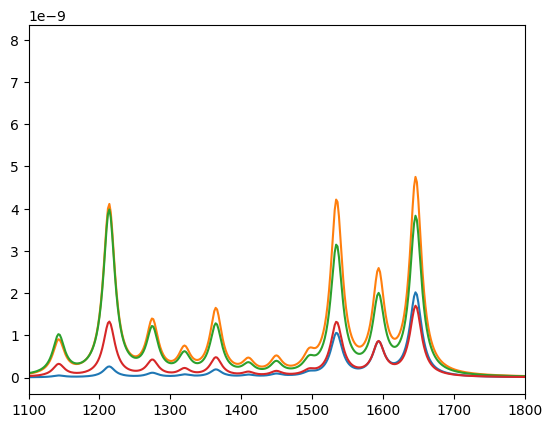

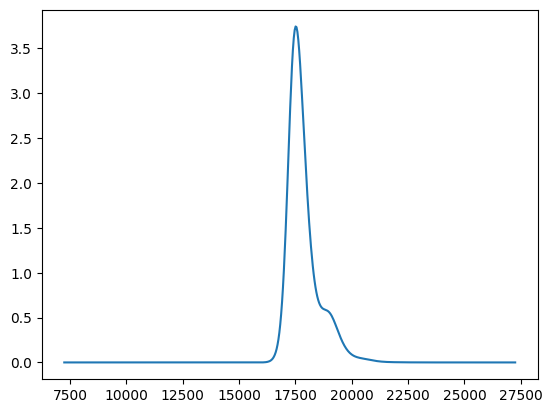

In [3]:
import matplotlib.pyplot as plt
load("freqs","deltas","rpumps","inp.txt")
main()
for i in range(len(rpumps)-1):
    plt.plot(rshift.clone().cpu().numpy(),raman_spec[:,i].clone().cpu().numpy())
plt.xlim(1100,1800)
fig, ax = plt.subplots()


plt.plot(convEL.clone().cpu().numpy(),abs_cross.clone().cpu().numpy())
plt.show()

In [55]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch import nn
import torch.autograd.profiler as profiler
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

colors = plt.cm.viridis(np.linspace(0, 1, len(wg)))#divide color map to number of freqs
cmap = ListedColormap(colors)

class MyModule(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super(MyModule, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)

    def forward(self, input, mask):
        with profiler.record_function("LINEAR PASS"):
            out = self.linear(input)

        with profiler.record_function("MASK INDICES"):
            threshold = out.sum(axis=1).mean().item()
            hi_idx = np.argwhere(mask.cpu().numpy() > threshold)
            hi_idx = torch.from_numpy(hi_idx).cuda()

        return out, hi_idx


def raman_sigma(torchparams):
    global rcross_exp, gamma, M, correlation

    for i in range(len(delta)):
        if torchparams[i]>1:
            delta[i] = 1
        elif torchparams[i]<0:
            delta[i] = 0
        else:
            delta[i] = torchparams[i]
    gamma = torchparams[len(delta)]
    M = torchparams[len(delta)+1]
    k = float(inp[3]) # kappa parameter
    D =  gamma*(1+0.85*k+0.88*k**2)/(2.355+1.76*k) # D parameter 
    L =  k*D # LAMBDA parameter
    #print(delta)
    abs_cross,fl_cross,raman_cross,boltz_states,boltz_coef  = cross_sections(convEL,delta,theta,D,L,M,E0)
    stacked_tensors = torch.stack((torch.real(abs_cross), abs_exp.t()[1]), dim=0)
    correlation_matrix = torch.corrcoef(stacked_tensors)
    correlation = correlation_matrix[0, 1]
    print("Correlation of absorption is "+ str(correlation))
    #correlation =-(correlation-1) #Minimize the negative correlation to get better fit
    if rcross_exp.ndim == 1:    #Convert 1D array to 2D
        rcross_exp = torch.reshape(rcross_exp,(-1,1))
        #print("Raman cross section expt is converted to a 2D array")
    sigma = torch.zeros((len(wg)+1), dtype=torch.float32,device=device)
    for i in range(len(rpumps)):
    #rp = min(range(len(convEL)),key=lambda j:abs(convEL[j]-rpumps[i]))
        min_diff = torch.tensor(1.0e4,device=device)
        rp = None

        for j in range(len(convEL)):
            diff = torch.abs(convEL[j] - rpumps[i])
            if diff < min_diff:
                min_diff = diff
                rp = j
        #print(rp)
        for j in range(len(wg)):
            #print(j,i)
            sigma[j] = sigma[j] + (1e7*(torch.real(raman_cross[j,rp])-rcross_exp[j,i]))**2   
    sigma_delta = torch.sum(sigma)
    loss = sigma_delta-(correlation-1)
    
    print("Total sigma is "+ str(sigma_delta))
    
 
    return loss

def raman_loss(prediction,target):
    loss = torch.abs(raman_sigma(prediction) - raman_sigma(target))
    return loss

def minimize(function, initial_parameters,max_iterations,lr):
    global cmap
    list_params = [0 for _ in range(max_iterations)] #Input of parameter is a numpy array of tensors
    list_correlation = []
    list_values = []

    writer = SummaryWriter()

    tolerance = 1e-4
    
    optimizer = optim.Adam(initial_parameters, lr=lr)

    #with profiler.profile(with_stack=True, profile_memory=True) as prof:
    for iteration in range(max_iterations):
        # Calculate the loss
        loss = function(initial_parameters)

        # Backpropagation
        writer.add_scalar("Loss/train", loss, iteration)
        writer.add_scalar("correlation/train", correlation, iteration)
        
        loss.backward()  # Compute gradients          
        
        list_values.append(loss.clone().detach().cpu())
        list_params[iteration] = torch.cat((torch.cat((delta,gamma)),M))
        list_correlation.append(correlation.clone().detach().cpu())
        '''
        ax.clear()
        for i in range(len(rpumps)): #iterate over pump wn
        #rp = min(range(len(convEL)),key=lambda j:abs(convEL[j]-rpumps[i]))
            min_diff = float('inf')
            rp = None

            for j in range(len(convEL)): #iterate over all exitation wn to find the one closest to pump 
                diff = np.absolute(convEL.cpu()[j] - rpumps.cpu()[i])
                if diff < min_diff:
                    min_diff = diff
                    rp = j
            #print(rp)
            for j in range(len(wg)): #iterate over all raman freqs 
                #print(j,i)
                #sigma[j] = sigma[j] + (1e8*(np.real(raman_cross[j,rp])-rcross_exp[j,i]))**2
                color = cmap(j)
                ax.plot(convEL.cpu(),raman_cross.cpu().t()[:,j],color = color)
                
                ax.plot(convEL.cpu()[rp],rcross_exp.cpu()[j,i],"o",color = color)

        ax.set_xlim(16000,22500)
        #ax.set_ylim(0,0.5e-7)
        display(fig)
        clear_output(wait=True)

        #ax2.clear()
        ax2.plot(convEL.cpu(),torch.real(abs_cross).detach().cpu())
        ax2.plot(convEL.cpu(),torch.real(fl_cross).detach().cpu())
        ax2.plot(convEL.cpu(),abs_exp.detach().cpu().t()[1])
        display(fig2)
        clear_output(wait=True)
        '''
        optimizer.step()# Update parameters
        optimizer.zero_grad()  # Zero out gradients from previous iteration

        # Check for convergence
        if loss.item() < tolerance:
            break 
    #print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))
    #print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10)) 
    writer.flush()
    writer.close()
    list_params = [[tensor.detach().cpu().numpy().item() for tensor in row] for row in list_params]
    torch.save(list_params,'params_opt.pt') 
    main()






    return list_values, list_correlation,  list_params

def initialize_torch(abs_inp,rcross_inp):
    global abs_exp, rcross_exp
    load("freqs","deltas","rpumps","inp.txt")
    convert_to_pt(abs_inp+'.dat',abs_inp+'.pt')
    convert_to_pt(rcross_inp+'.dat',rcross_inp+'.pt')
    # Load data to the GPU and convert to PyTorch tensors
    abs_exp = torch.tensor(torch.load(abs_inp +'.pt'), dtype = torch.float32, device=device)  
    rcross_exp = torch.tensor(torch.load(rcross_inp +'.pt'), dtype = torch.float32, device=device)  

def torch_corrcoef(tensor1, tensor2):
    # Stack the tensors along a new dimension
    stacked_tensors = torch.stack((tensor1, tensor2), dim=0)

    # Calculate the correlation coefficient
    correlation_matrix = torch.corrcoef(stacked_tensors)

    # Extract the correlation coefficient from the matrix
    correlation_coefficient = correlation_matrix[0, 1]

    return correlation_coefficient


    

In [71]:
initialize_torch('O2_abs','rshift_exp')
print(raman_cross.ndim)
print(torch.real(abs_cross).size()) 
print(abs_exp.t()[1].size())




2
torch.Size([500])
torch.Size([500])


C:\Users\kentc\AppData\Local\Temp\ipykernel_5000\1899161672.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wg = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Ground state normal mode frequencies cm^-1
C:\Users\kentc\AppData\Local\Temp\ipykernel_5000\1899161672.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  we = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Excited state normal mode frequencies cm^-1
C:\Users\kentc\AppData\Local\Temp\ipykernel_5000\1899161672.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

In [56]:

#torch.autograd.set_detect_anomaly(True)
writer = SummaryWriter()
#params_lmfit = param_init("deltas.dat","O2_abs.dat")
initialize_torch('O2_abs','rshift_exp')
#torchparams = torch.zeros([len(delta),1],dtype = torch.float32,device = cuda0)
torchparams = list()
for i in range(len(delta)):
    torchparams.append(torch.tensor([delta[i].clone().item()],dtype = torch.float,device = device,requires_grad=True))
    #-ln((1 / (x + 1e-8)) - 1)
gamma_tensor = torch.tensor([gamma], dtype=torch.float, device = device,requires_grad=True)
M_tensor = torch.tensor([M], dtype=torch.float, device = device,requires_grad=True)                           
torchparams.append(gamma_tensor)
torchparams.append(M_tensor)
#print(torchparams)

list_values, list_correlation, list_params = minimize(raman_sigma, torchparams ,20000,0.1)
print(list_values)
print(list_correlation)
print(list_params)
'''
for i in range(max_iterations):
    lr = 0.1*(np.tanh(-2*i/max_iterations)+1)
optimizer = optim.Adam(torchparams, lr=lr)

values = []
with profiler.profile(with_stack=True, profile_memory=True) as prof:
    for iteration in range(max_iterations):
        # Calculate the loss
        loss = raman_sigma(torchparams)

        # Backpropagation
        writer.add_scalar("Loss/train", loss, iteration)
        writer.add_scalar("Loss/train", correlation, iteration)
        loss.backward()  # Compute gradients
        optimizer.step()# Update parameters
        optimizer.zero_grad()  # Zero out gradients from previous iteration
        
        
        values.append(loss.clone().detach().cpu())
        # Check for convergence
        if loss.item() < tolerance:
            break
print(torchparams)
#optimal_parameter = torchparams.item()
#plt.plot(values)
#starting_point = torchparams
#minimized_params, list_of_params = minimize(raman_sigma, starting_point)
#print(list_of_params)

writer.close()
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
'''

C:\Users\kentc\AppData\Local\Temp\ipykernel_3976\943053784.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wg = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Ground state normal mode frequencies cm^-1
C:\Users\kentc\AppData\Local\Temp\ipykernel_3976\943053784.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  we = torch.tensor(torch.load(freqs+'.pt'), device=device)  # Excited state normal mode frequencies cm^-1
C:\Users\kentc\AppData\Local\Temp\ipykernel_3976\943053784.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

Correlation of absorption is tensor(0.9379, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(10.4124, device='cuda:0')
Correlation of absorption is tensor(0.9379, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(17.5224, device='cuda:0')
Correlation of absorption is tensor(0.9379, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(13.7714, device='cuda:0')
Correlation of absorption is tensor(0.9380, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(12.1369, device='cuda:0')
Correlation of absorption is tensor(0.9380, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(13.7773, device='cuda:0')
Correlation of absorption is tensor(0.9380, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(14.4575, device='cuda:0')
Correlation of absorption is tensor(0.9381, device='cuda:0', grad_fn=<SelectBackward0>)
Total sigma is tensor(13.8363, device='cuda:0')
Correlation of absorption is tensor(0.9381, devi

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

tensor([0.6144, 0.5101, 0.4673, 0.1706, 0.1349, 0.3116, 0.1022, 0.0971, 0.2424,
        0.1281, 0.1626, 0.0455, 0.0616, 0.0658, 0.0599, 0.1077, 0.2275, 0.1213,
        0.0809, 0.1328, 0.0593, 0.0657, 0.0655, 0.2240, 0.1739, 0.2559],
       device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)


c:\Python311\Lib\site-packages\torch\_tensor.py:1032: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


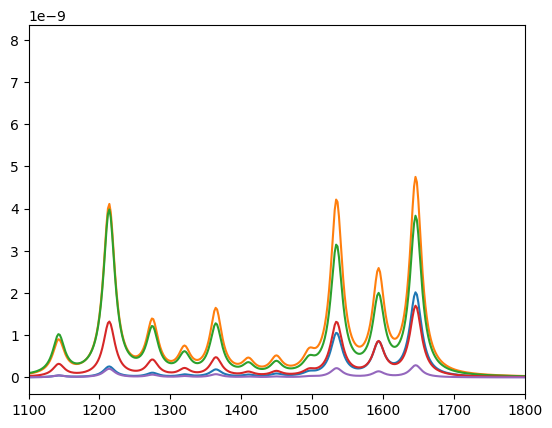

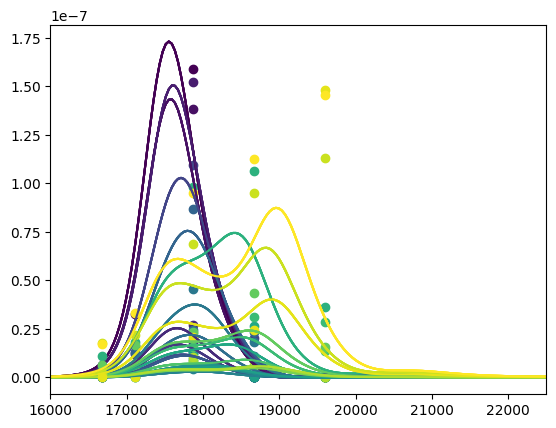

<function matplotlib.pyplot.show(close=None, block=None)>

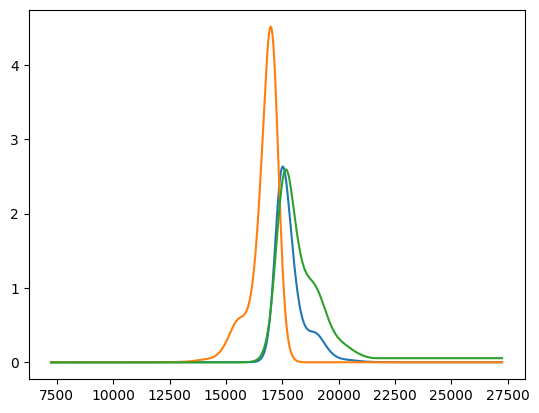

In [33]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

colors = plt.cm.viridis(np.linspace(0, 1, len(wg)))#divide color map to number of freqs
cmap = ListedColormap(colors)
'''
load("freqs.dat","deltas.dat","rpumps.dat","inp.txt")
for i in range(len(delta)):
    delta[i]= result.params.valuesdict()["delta"+str(i)]
gamma = result.params.valuesdict()['gamma']
M = result.params.valuesdict()['transition_length']
D =  gamma*(1+0.85*k+0.88*k**2)/(2.355+1.76*k) # D parameter 
L =  k*D # LAMBDA parameter
main()
rcross_exp = np.asarray(np.loadtxt("rshift_exp.dat"))
raman_spec=np.loadtxt("data/raman_spec.dat")
rs = np.loadtxt("data/rshift.dat")
ex_prof = np.loadtxt("data/profs.dat")
ex_energy = np.loadtxt("data/EL.dat")
abs = np.loadtxt("data/Abs.dat")
fl = np.loadtxt("data/fl.dat")
'''

print(delta)

for i in range(len(rpumps)):
    plt.plot(rshift.cpu(),raman_spec.cpu()[:,i])
plt.xlim(1100,1800)
fig, ax = plt.subplots()

for i in range(len(rpumps)): #iterate over pump wn
#rp = min(range(len(convEL)),key=lambda j:abs(convEL[j]-rpumps[i]))
    min_diff = float('inf')
    rp = None

    for j in range(len(convEL)): #iterate over all exitation wn to find the one closest to pump 
        diff = np.absolute(convEL.cpu()[j] - rpumps.cpu()[i])
        if diff < min_diff:
            min_diff = diff
            rp = j
    #print(rp)
    for j in range(len(wg)): #iterate over all raman freqs 
        #print(j,i)
        #sigma[j] = sigma[j] + (1e8*(np.real(raman_cross[j,rp])-rcross_exp[j,i]))**2
        color = cmap(j)
        ax.plot(convEL.cpu(),raman_cross.cpu().t()[:,j],color = color)
        
        ax.plot(convEL.cpu()[rp],rcross_exp.cpu()[j,i],"o",color = color)

ax.set_xlim(16000,22500)
#ax.set_ylim(0,0.5e-7)
plt.show()
fig2,ax2 = plt.subplots()
ax2.plot(convEL.cpu(),torch.real(abs_cross).detach().cpu())
ax2.plot(convEL.cpu(),torch.real(fl_cross).detach().cpu())
ax2.plot(convEL.cpu(),abs_exp.detach().cpu().t()[1])
plt.show

[0.8   0.65  0.6   0.15  0.15  0.45  0.19  0.15  0.39  0.22  0.21  0.081
 0.11  0.1   0.15  0.1   0.37  0.15  0.17  0.22  0.12  0.13  0.15  0.31
 0.15  0.33 ]
[19607. 18692. 17857. 17094. 16667.]
[0.8        0.65       0.6        0.15       0.15       0.45
 0.19       0.15       0.39       0.22       0.21       0.081
 0.11       0.1        0.15       0.1        0.37       0.15
 0.17       0.22       0.12       0.13       0.15       0.31
 0.15       0.58309382]


IndexError: list index out of range

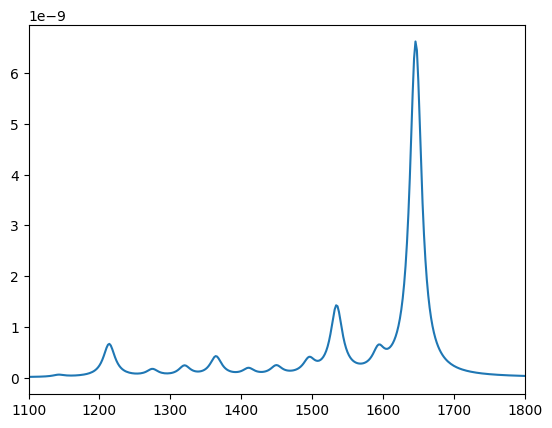

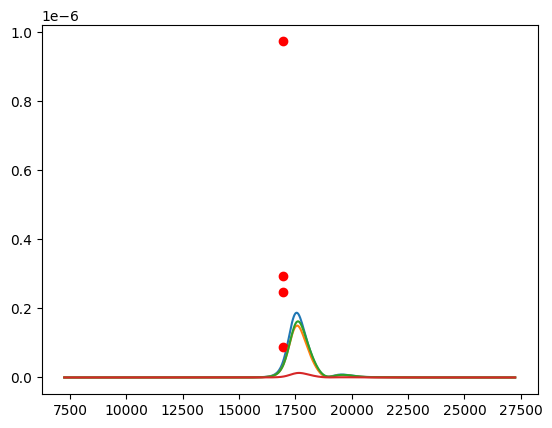

In [ ]:
load("freqs.dat","deltas.dat","rpumps.dat","inp.txt")
for i in range(len(delta)):
    delta[i]= result.params.valuesdict()["delta"+str(i)]
main()
rcross_exp = [8.884521225073237e-08,2.468053354960988e-07,2.925094459548995e-07,9.713536030854094e-07]
print(delta)
raman_spec=np.loadtxt("data/raman_spec.dat")
rs = np.loadtxt("data/rshift.dat")
ex_prof = np.loadtxt("data/profs.dat")
ex_energy = np.loadtxt("data/EL.dat")
abs = np.loadtxt("data/Abs.dat")
fl = np.loadtxt("data/fl.dat")
plt.plot(rs,raman_spec[:,0])
plt.xlim(1100,1800)
fig, ax = plt.subplots()
sigma = 0
for i in range(ex_prof.shape[1]):
    #print(ex_prof[242,i]) #480nm pump
    sigma = sigma + (ex_prof[242,i]-rcross_exp[i])**2
    ax.plot(ex_energy,ex_prof[:,i])
    ax.plot(ex_energy[242],rcross_exp[i],"ro")
ax.set_xlim(17500,22500)
plt.show()
fig2,ax2 = plt.subplots()
ax2.plot(ex_energy,abs)
ax2.plot(ex_energy,fl)
plt.show
print(sigma)